# Profit Optimization via Reinforcement Learning

This notebook formalizes a discrete-time decision process for marketing investment. The agent selects a marketing action \(a_t\) at each period based on the state vector

	\( s_t = (	ext{demand}_t, 	ext{brand}_t, 	ext{cash}_t ) \).

The goal is to approximate the value function \(V(s)\) using TD(0) and to evaluate the behavior of a simple policy.


## Setup

Core scientific stack and display configuration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple

plt.style.use('seaborn-v0_8')


## Environment

The system evolves as a Markov decision process. Demand and brand follow controlled stochastic transitions. Cash evolves through deterministic revenue and stochastic cost. The reward is defined as revenue minus marketing cost.

State transitions follow

	\( s_{t+1} \sim P(s_{t+1} | s_t, a_t) \).

We parameterize revenue as

	\( r(s_t, a_t) = lpha \cdot 	ext{demand}_t + eta \cdot 	ext{brand}_t - c(a_t) \)


In [3]:
@dataclass(frozen=True)
class CompanyState:
    demand: int
    brand: int
    cash: int


class CompanyEnv:
    def __init__(self, gamma=0.9, seed=42, horizon=20):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)
        self.horizon = horizon
        self.state = CompanyState(1, 1, 2)

    def reset(self):
        self.state = CompanyState(1, 1, 2)
        return self.state

    def step(self, action: int) -> Tuple[CompanyState, float]:
        d, b, c = self.state.demand, self.state.brand, self.state.cash
        demand_next = max(0, min(3, d + self.rng.integers(-1, 2) + action - 1))
        brand_next = max(0, min(3, b + (1 if action == 2 else 0)))
        cost = [0, 1, 2][action]
        revenue = d * 2 + b
        cash_next = max(0, min(3, c + revenue - cost))
        reward = revenue - cost
        self.state = CompanyState(demand_next, brand_next, cash_next)
        return self.state, reward


## Policy

A simple heuristic selects actions based on available cash and marginal demand conditions.

In [4]:
def marketing_policy(state: CompanyState) -> int:
    if state.cash == 0:
        return 0
    if state.demand <= 1:
        return 1
    return 2


## Temporal Difference Learning

We approximate the value function using TD(0). For each visited transition

	\( V(s_t) \leftarrow V(s_t) + \alpha [r_t + \gamma V(s_{t+1}) - V(s_t)] \).

Sampling trajectories under the policy yields a Monte Carlo rollout used to drive temporal-difference updates.

In [8]:
def td0(env: CompanyEnv, alpha=0.2, episodes=5000) -> Dict[CompanyState, float]:
    V: Dict[CompanyState, float] = {}
    for _ in range(episodes):
        s = env.reset()
        for _ in range(env.horizon):
            a = marketing_policy(s)
            s_next, r = env.step(a)
            V.setdefault(s, 0.0)
            V.setdefault(s_next, 0.0)
            V[s] += alpha * (r + env.gamma * V[s_next] - V[s])
            s = s_next
    return V

env = CompanyEnv(seed=21, horizon=20)
value_function = td0(env)


## Value Structure

Sort states by estimated value to inspect where the policy invests effectively.

In [9]:
sorted_V = sorted(value_function.items(), key=lambda x: -x[1])
for s, v in sorted_V[:10]:
    print(s, f"V={v:.2f}")


CompanyState(demand=3, brand=3, cash=3) V=70.00
CompanyState(demand=3, brand=2, cash=3) V=69.00
CompanyState(demand=2, brand=3, cash=3) V=66.72
CompanyState(demand=2, brand=2, cash=3) V=65.65
CompanyState(demand=2, brand=1, cash=3) V=64.07
CompanyState(demand=1, brand=1, cash=3) V=47.83
CompanyState(demand=1, brand=1, cash=2) V=42.91
CompanyState(demand=0, brand=1, cash=3) V=36.81


## Heatmap by Cash

Fixing cash produces a bivariate surface across demand and brand. This highlights the sensitivity of value to the two main growth levers.

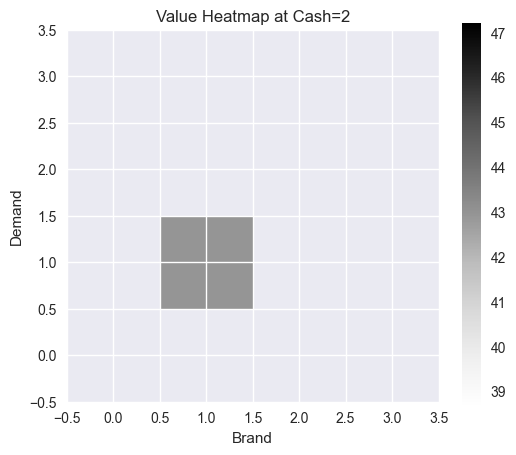

In [10]:
def plot_value_heatmap(V: Dict[CompanyState, float], cash: int):
    grid = np.zeros((4, 4))
    for d in range(4):
        for b in range(4):
            grid[d, b] = V.get(CompanyState(d, b, cash), np.nan)
    plt.figure(figsize=(6, 5))
    plt.imshow(grid, origin='lower')
    plt.colorbar()
    plt.xlabel('Brand')
    plt.ylabel('Demand')
    plt.title(f'Value Heatmap at Cash={cash}')
    plt.show()

plot_value_heatmap(value_function, cash=2)


## Sample Trajectory

A rollout under the heuristic policy shows how the controlled dynamics evolve.

In [11]:
env_t = CompanyEnv(seed=7, horizon=30)
trajectory = []
s = env_t.reset()
total_reward = 0
for _ in range(env_t.horizon):
    a = marketing_policy(s)
    s_next, r = env_t.step(a)
    trajectory.append((s, a, r, s_next))
    total_reward += r
    s = s_next

for t in trajectory:
    print(t)

total_reward


(CompanyState(demand=1, brand=1, cash=2), 1, 2, CompanyState(demand=2, brand=1, cash=3))
(CompanyState(demand=2, brand=1, cash=3), 2, 3, CompanyState(demand=3, brand=2, cash=3))
(CompanyState(demand=3, brand=2, cash=3), 2, 6, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=3, brand=3, cash=3), 2, 7, CompanyState(demand=3, brand=3, cash=3))
(CompanyState(demand=

200

# SARSA

In [ ]:
def epsilon_greedy(Q, state, epsilon):

    if state not in Q:
        Q[state] = np.zeros(5)

    rand = np.random.random()

    if rand < epsilon:
        return np.random.choice(5)
    else:
        return np.argmax(Q[state])


In [ ]:
def sarsa(env, alpha, gamma, epsilon, num_steps):
    
    Q = {}

    state = env.reset()
    action = epsilon_greedy(Q, state, epsilon)

    for t in range(num_steps):
        next_state, reward, done, _ = env.step()

        next_action = epsilon_greedy(Q, next_state, epsilon)

        if next_state not in Q:
            Q[next_state] = np.zeros(5)
        
        if state not in Q:
            Q[state] = np.zeros(5)

        Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

        state = next_state 
        action = next_action

    return Q